# Genome-scale metabolic modeling

Metabolic reactions underpin cellular function, converting nutrients into energy and cellular building blocks. Genome-scale metabolic models (GEMs) offer a holistic representation of these pathways based on an organism's genome, providing insights into its metabolic potential under various conditions. GEMs represent the collection of metabolic reactions as a [biochemical network](https://en.wikipedia.org/wiki/Metabolic_network), in which nodes represent metabolites (chemical compounds) and edges are reactions in which these metabolites participate either as substrates or as products. Additionally, GEMs include the _stoichiometry_ with which a metabolite participates in each reaction (that is, the number of molecules of each metabolite involved in the reaction).By convention, positive stoichiometric coefficients represent products and negative stoichiometric coefficients represent substrates.

> As a curiosity, biochemical networks cannot be represented by simple graphs, but rather by [hypergraphs](https://en.wikipedia.org/wiki/Hypergraph), in which edges connect more than two nodes. This is because biochemical reactions may involve multiple substrates and products. 

As in with any graph, we can represent a biochemical network by its [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix), the stoichiometric matrix, $S$, which is a central piece of a GEM. In $S$, columns represent reactions and rows metabolites. Thus, its entries $s_{ij}$ represent the stoichiometric coefficient of metabolite $i$ in reaction $j$. Most metabolites participate in a small number of reactions, so $S$ is a sparse matrix, where most of its entries are 0.

### A toy network example

Here is a toy biochemical network with 6 metabolites $A-F$ and 5 reactions $R_{1-5}$ to help us visualize how the stoichiometric matrix is constructed. Note that in this case all stoichiometric coefficients are 1, but in actual GEMs they can be any integer (or even a fraction in the case of the biomass pseudo-reaction). Note that column vectors represent reactions, while row vectors, metabolites:

<div style="width:100%; text-align:center;">
<img src="images/toy_network.png" alt="toy network" style="width: 20%; height: auto; margin: auto">
</div>

The stoichiometric matrix $S$ is constructed by stacking the column vectors of the network, so that the first column of $S$ is the vector representing reaction $R_1$, while the first row of $S$ is the vector representing metabolite $A$, and so on. Thus, the first entry of $S$ is the stoichiometric coefficient of metabolite $A$ in reaction $R_1$ (acting as a substrate in this case):

$$
S = 
\begin{align*}
\begin{pmatrix}
-1 & 0 & 0 & -1 & 0 \\
1 & -1 & 0 & 0 & 0 \\
1 & 1 & -1 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & -1 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{align*}
$$

Now, reactions transform substrates into products at a given rate, or flux. This flux is typically measured in $mmol$ of transformed product per unit time per dry weight. The interesting thing about $S$ is that it allows us to model reaction fluxes, let's name the vector of fluxes $v$. The flux vector $v$ is a vector of real numbers, where each entry $v_j$ represents the flux of reaction $j$, and it is related to the stoichiometric matrix $S$ by the following equation:

$$\frac{d}{dt}x = Sv,$$

and under [steady-state]() conditions, where the concentration of each metabolite is constant, we have:

$$Sv = 0.$$

The above is typically an underdetermined system of linear equations. Thus, instead of a single solution, we end up with a space of possible solutions, $v$, which is called the _nullspace_ of $S$. However, reaction fluxes are subject to maximum capacity and thermodynamic constraints. Ther former restricts the maximum flux of each reaction, while the latter restricts the direction of fluxes. These constraints are typically represented by a vector of lower and upper bounds, $v_{min}$ and $v_{max}$, respectively. Thus, the space of possible solutions is further restricted to the _feasible flux space_, a.k.a. the [flux cone]() $F$, which is the set of all flux vectors satisfying:

$$F = \{v: Sv = 0, v_{min} \leq v \leq v_{max}\}.$$ 


# Genome-scale models in cobrapy

`cobrapy` (COnstraint-Based Reconstruction and Analysis in PYthon) is a Python package for constraint-based modeling of metabolic networks. It provides a set of tools for the analysis of GEMs, including the ability to read and write GEMs in the [SBML]() format, and to perform [flux balance analysis]() (FBA) and [flux variability analysis]() (FVA). In this tutorial, we will use `cobrapy` to analyze a GEM of the marine diatom [_Thalassiosira pseudonana_](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0241960).

In [12]:
import numpy as np
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from phycogem.reconstruction import GEM

In [13]:
gem = GEM("../data/models/iTps1432_high.xml")
# gem = GEM("../results/models/MAG_00212_pseudonitzschia_photoeuk_noSK.xml")

# Rescale maximum flux
gem.rescale_fluxes(maximum_flux=1000)
gem

Read LP format model from file /tmp/tmpxlxl643n.lp
Reading time = 0.03 seconds
: 2792 rows, 12158 columns, 53548 nonzeros


Name,iTps1432
Memory address,7f407a101810
Number of metabolites,2792
Number of reactions,6079
Number of genes,1432
Number of groups,93
Objective expression,4.0*DM_biomass_c - 4.0*DM_biomass_c_reverse_c49c1
Compartments,"plastid, mitochondria, cytosol, peroxisome, thylakoid membrane, extracellular"


In the summary above, we see that the model contains over 6000 biochemical reactions and more than 2700 metabolites, which are partitioned into 6 compartments: plastid, mitochondria, cytosol, peroxisome, thylakoid membrane and extracellular space. Note that _Thalassiosira_ is a phototrophic eukaryote (a microalga), thus it contains chloroplasts alongside mitochondria. A special reaction within the model is the _biomass_ reaction, a pseudo-reaction that represents the growth of the organism (more on this later), and which is set as the objective function of the model.

We can extract the stoichiometric matrix of the model as follows:

In [14]:
S = cobra.util.create_stoichiometric_matrix(gem.model)
print(f"The shape of S is {S.shape}")
print(f"S contains {100 * np.count_nonzero(S) / S.size}% non-zero elements")
print(" ")
print(S)

The shape of S is (2792, 6079)
S contains 0.1577486683217295% non-zero elements
 
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.04010769  0.
   0.        ]
 [ 0.          0.          0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.01311877  0.
   1.        ]]


As expected, the number of rows of the stoichiometric matrix $S$ coincides with the number of metabolites in the model, while the number of columns is the number of reactions. Additionally, only 15.8% of its entries (stoichiometric coefficients) are non-zero, which is a consequence of the sparsity of the matrix.

## Flux balance analysis

In [15]:
# Set growth medium (autotroph)
medium_id = "MARINE" #"MARINE[iTPS1432]"
energy_source = ("EX_photon_e", 1000) # ("EX_photon650_e", 200)
gem.set_medium(medium_id, "../data/marine_media/media_db.tsv", energy_source=energy_source)

# Optimize biomass production
sol = gem.model.optimize()
print(f"The maximum growth rate is {sol.objective_value:.2f} 1/h")

Carbon source EX_photon_e not found in model.
The maximum growth rate is 0.00 1/h


### Nitrogen sources

In [16]:
gem.model.reactions.get_by_id("EX_no3_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_nh4_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_no2_e").lower_bound = 0
gem.model.reactions.get_by_id("EX_urea_e").lower_bound = -0.1

### Plot biomass vs maximum nitrogen uptake rate

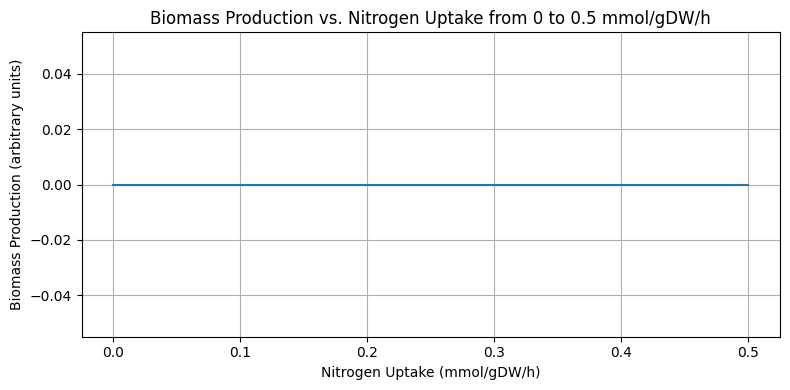

In [17]:
nitrogen_fluxes = np.linspace(0, 0.5, 100)
biomass_values = []

for no3_influx in nitrogen_fluxes:
    gem.model.reactions.get_by_id('EX_urea_e').lower_bound = -no3_influx
    solution = gem.model.optimize()
    biomass_values.append(4 * solution.fluxes['DM_biomass_c'])

plt.figure(figsize=(8, 4))
plt.plot(nitrogen_fluxes, biomass_values, color='tab:blue')
plt.xlabel('Nitrogen Uptake (mmol/gDW/h)')
plt.ylabel('Biomass Production (arbitrary units)')
plt.title('Biomass Production vs. Nitrogen Uptake from 0 to 0.5 mmol/gDW/h')
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyzing the flux cone: flux variability analysis and flux sampling

In [18]:
# Run flux variability analysis and sampling
fva = gem.compute_flux_ranges()
fva

,minimum,maximum
IDP_m,0.0,250.250
ATAM_c,0.0,250.375
GLTS_c,0.0,0.500
GLNA_h,0.0,400.600
GLNA_m,0.0,400.400
...,...,...
biomass_chitin_c,0.0,0.000
biomass_frustule_c,0.0,0.000
bof200_c,0.0,0.000
biomass_EPS_c,0.0,0.000


In [19]:
sample = gem.sample_flux_space(n_samples=1000, n_processes=14)
# sample.to_csv("../results/flux_samples/ps_photoeuk_noSK.csv")

sample = pd.read_csv("../results/flux_samples/iTps1432_high.csv", index_col=0)
sample

Read LP format model from file /tmp/tmp66s0y3a8.lp
Reading time = 0.03 seconds
: 2792 rows, 12158 columns, 53548 nonzeros


,IDP_m,ATAM_c,GLTS_c,GLNA_h,GLNA_m,FACOAL_181_9Z_c,ACS_c,UTAL_h,UTAL_c,ASPTA_L_h,...,biomass_mem_lipids_c,biomass_TAG_c,biomass_pigm200_h,biomass_osmo_c,biomass_vit_c,biomass_chitin_c,biomass_frustule_c,bof200_c,biomass_EPS_c,biomass_polyp_c
0,0.001086,11.486232,0.000003,0.241618,10.550760,0.000211,0.000017,0.000216,2.253365e-09,-0.008908,...,0.000513,0.000045,0.000114,0.000175,0.000012,0.000215,0.000223,0.005568,0.000167,0.000073
1,0.062240,11.549334,0.000003,0.237371,10.544683,0.000218,0.000018,0.000216,2.253365e-09,-0.003919,...,0.000513,0.000045,0.000114,0.000175,0.000012,0.000215,0.000223,0.005568,0.000167,0.000073
2,0.065788,11.555583,0.000003,0.223800,10.542532,0.000254,0.000028,0.000216,2.883851e-07,-0.001527,...,0.000514,0.000045,0.000114,0.000175,0.000012,0.000215,0.000224,0.005575,0.000163,0.000073
3,0.065885,11.555562,0.000003,0.223279,10.535281,0.000252,0.000026,0.000216,2.883851e-07,-0.001529,...,0.000514,0.000045,0.000115,0.000175,0.000012,0.000215,0.000224,0.005575,0.000163,0.000073
4,0.065889,11.555168,0.000003,0.223269,10.535268,0.000262,0.000038,0.000216,2.883850e-07,-0.001523,...,0.000514,0.000045,0.000115,0.000175,0.000012,0.000215,0.000224,0.005575,0.000163,0.000073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8.583281,18.204882,0.007249,4.759518,16.292420,0.290366,0.032599,0.000825,3.018054e-06,-0.020896,...,0.001967,0.000172,0.000438,0.000670,0.000046,0.000824,0.000856,0.021332,0.000236,0.000280
996,8.838178,18.496816,0.007250,4.835402,16.253553,0.276632,0.031884,0.000825,3.019245e-06,-0.020672,...,0.001966,0.000172,0.000438,0.000670,0.000046,0.000823,0.000855,0.021319,0.000123,0.000280
997,9.086933,18.767943,0.007251,4.839884,16.112378,0.270618,0.032016,0.000827,3.021114e-06,-0.021825,...,0.001971,0.000172,0.000439,0.000672,0.000046,0.000825,0.000857,0.021372,0.000091,0.000280
998,9.052552,18.745786,0.007250,4.915619,16.131213,0.270533,0.032689,0.000830,3.020258e-06,-0.021954,...,0.001979,0.000173,0.000441,0.000674,0.000047,0.000829,0.000861,0.021460,0.000007,0.000282


## Plot results

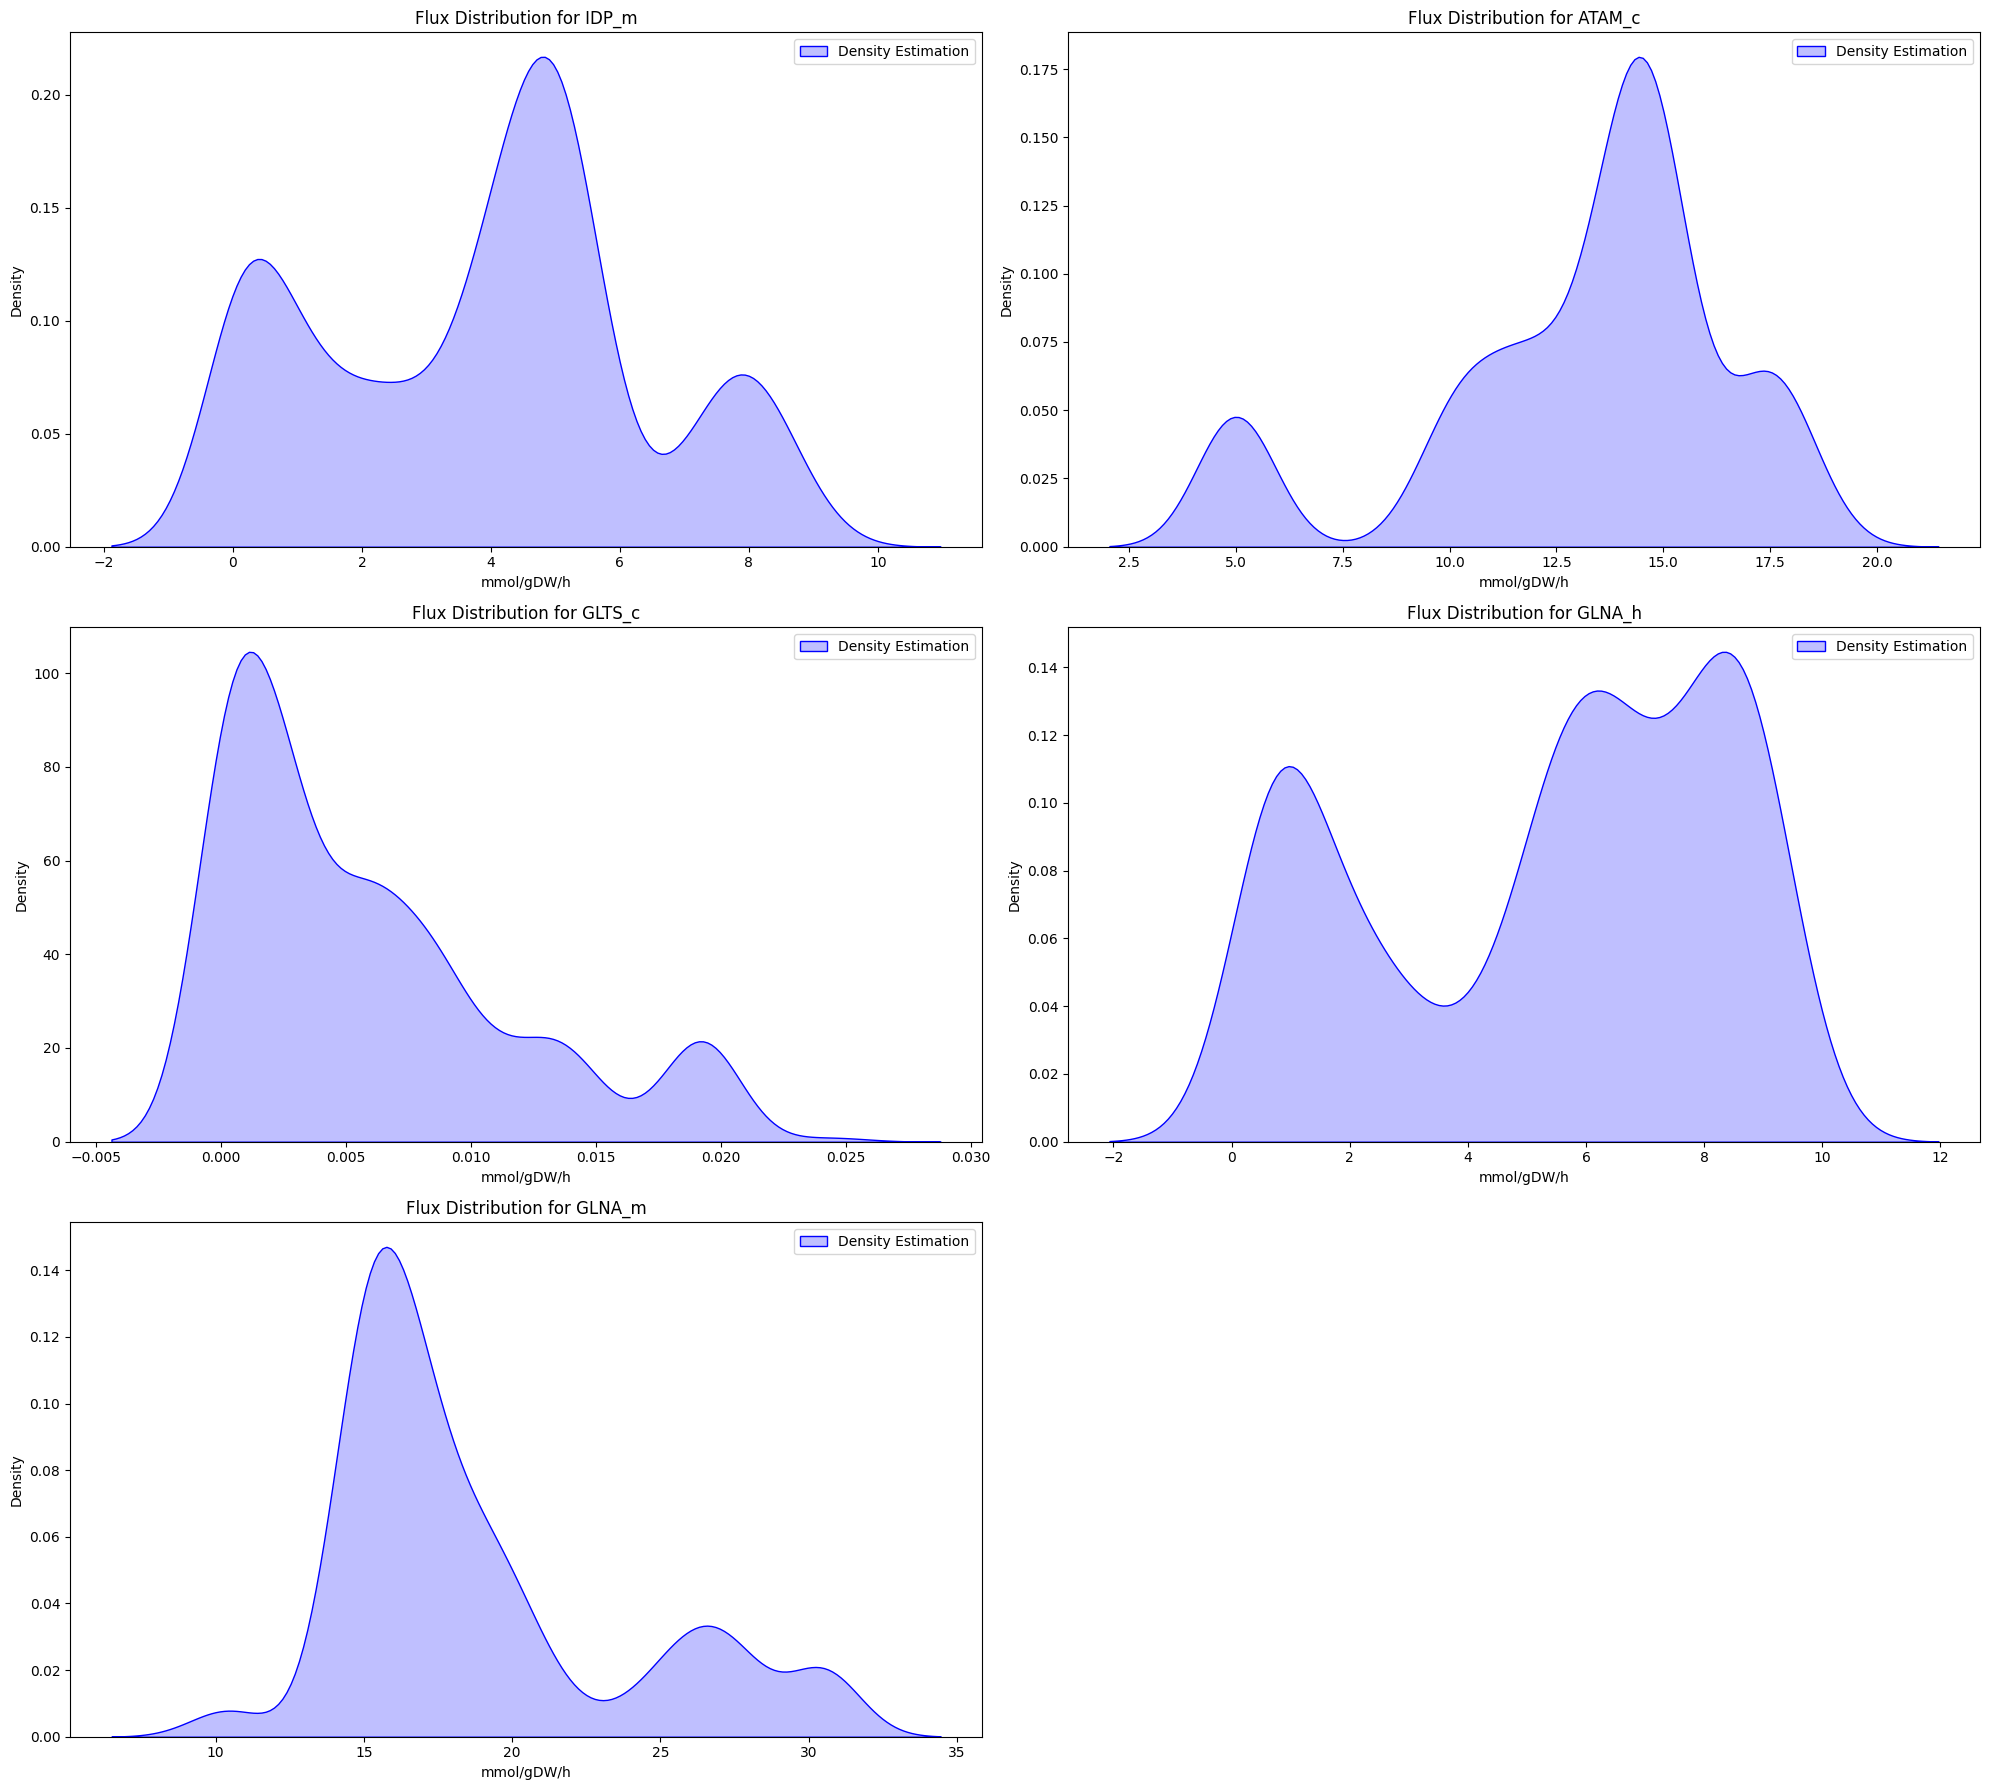

In [20]:
from phycogem.analysis import plot_flux_distribution


rxn_ids = sample.columns[:5].to_list()
plot_flux_distribution(sample, rxn_ids, fva=None)

In [21]:
# Compatibility with E. coli escher map
fluxes = gem.model.optimize().fluxes


base_ids = fluxes.index.str.extract(r'(.+?)_(?:c|h|m|x)')[0]
unique_reactions = base_ids[~base_ids.duplicated(keep=False)].unique()

# Function to handle the replacement
def custom_replace(s):
    base, comp = s.rsplit('_', 1)
    if base in unique_reactions or comp == 'c':
        return base
    else:
        return s
    

fluxes.index = fluxes.index.map(custom_replace)
fluxes

IDP_m               0.0
ATAM                0.0
GLTS                0.0
GLNA_h              0.0
GLNA_m              0.0
                   ... 
biomass_chitin      0.0
biomass_frustule    0.0
bof200              0.0
biomass_EPS         0.0
biomass_polyp       0.0
Name: fluxes, Length: 6079, dtype: float64

In [22]:
[rxn.id for rxn in gem.model.reactions if "mals" in rxn.id.lower()]

['MALS_x']

In [23]:
from escher import Builder


builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fluxes,
)
builder

Builder(reaction_data={'IDP_m': 0.0, 'ATAM': 0.0, 'GLTS': 0.0, 'GLNA_h': 0.0, 'GLNA_m': 0.0, 'FACOAL_181_9Z': …

## Get reaction IDs from escher maps

In [24]:
import json

def get_reaction_ids_from_escher_map(file_path):
    """
    Extract reaction IDs from an Escher map JSON file.

    Args:
    - file_path (str): Path to the Escher map JSON file.

    Returns:
    - List[str]: List of reaction IDs from the Escher map.
    """
    with open(file_path, 'r') as f:
        escher_map = json.load(f)[1]
    
    reaction_ids = [r['bigg_id'] for r in escher_map['reactions'].values()]
    
    return reaction_ids

In [25]:
from pathlib import Path


for file in Path("../data/escher_maps").iterdir():
    map_rxns = get_reaction_ids_from_escher_map(file)
    shared_rxns = np.intersect1d(fluxes.index.to_list(), map_rxns)
    print(f"Map: {file.stem}")
    print(f"Fraction of reactions represented in map: {len(shared_rxns) / len(map_rxns)}")


Map: iAF1260.Lipopolysaccharide_(LPS)_Biosynthesis
Fraction of reactions represented in map: 0.07142857142857142
Map: iJO1366.Fatty acid beta-oxidation
Fraction of reactions represented in map: 0.0
Map: iJO1366.Central metabolism
Fraction of reactions represented in map: 0.14146341463414633
Map: RECON1.Carbohydrate metabolism
Fraction of reactions represented in map: 0.10882352941176471
Map: iJO1366.Nucleotide metabolism
Fraction of reactions represented in map: 0.09051724137931035
Map: RECON1.Tryptophan metabolism
Fraction of reactions represented in map: 0.0
Map: iJO1366.Fatty acid biosynthesis (saturated)
Fraction of reactions represented in map: 0.2222222222222222
Map: RECON1.Amino acid metabolism (partial)
Fraction of reactions represented in map: 0.0926517571884984
Map: RECON1.COMBINED
Fraction of reactions represented in map: 0.05104867431737238
Map: RECON1.CARBOHYDRATE_METABOLISM
Fraction of reactions represented in map: 0.11046511627906977
Map: RECON1.Glycolysis TCA PPP
Fracti

In [26]:
# Find reacitons in the map not present in fluxes
file = "../data/escher_maps/e_coli_core.Core metabolism.json"
map_rxns = get_reaction_ids_from_escher_map(file)
missing_rxns = np.setdiff1d(map_rxns, fluxes.index.to_list())
missing_rxns

array(['ACALD', 'ACKr', 'ACONTa', 'ACONTb', 'ACt2r', 'ADK1', 'AKGDH',
       'AKGt2r', 'ALCD2x', 'ATPS4r', 'BIOMASS_Ecoli_core_w_GAM', 'CO2t',
       'CS', 'CYTBD', 'D_LACt2', 'ETOHt2r', 'EX_acald_e', 'EX_akg_e',
       'EX_fru_e', 'EX_fum_e', 'EX_glc__D_e', 'EX_mal__L_e', 'EX_pyr_e',
       'EX_succ_e', 'FORt2', 'FORti', 'FRD7', 'FRUpts2', 'FUMt2_2',
       'G6PDH2r', 'GAPD', 'GLCpts', 'GLNS', 'GLNabc', 'GLUDy', 'GLUN',
       'GLUSy', 'GLUt2r', 'GND', 'H2Ot', 'ICDHyr', 'LDH_D', 'MALt2_2',
       'ME2', 'NADH16', 'NADTRHD', 'NH4t', 'O2t', 'PDH', 'PIt2r', 'PPC',
       'PPCK', 'PPS', 'PTAr', 'PYRt2', 'SUCCt2_2', 'SUCCt3', 'SUCDi',
       'SUCOAS', 'TKT1', 'TKT2'], dtype='<U24')

## Different namespaces

Alright, what's happening is that there is a mismatch between reaction name spaces. For instance, 

* ACONTa, ACONTb are ACN_a_m, ACN_b_m in the model.
* SUCOAS is SCS_m
* AKGDH are OGDH_E1_m, OGDH_E2_m
* CS is CISY_m
* SUCDi is not present in the model!! ubiquinone-9 is present as metabolite but not in any reaction